In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
monthly_array_halocline_depth_SSslice = np.zeros([14,12,50,50])
monthly_array_halocline_strength_SSslice = np.zeros([14,12,50,50])

mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask,depth = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask','gdept_0')]
years, variables = range(2007, 2021), ['halocline','strength']


# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2015,2016,2017,2018,2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            q = ds.vosaline.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_halocline_depth_SSslice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            
            sal=ds.vosaline.isel(**slc).values
                      
             #get the gradient in salinity
            sal_grad = np.zeros_like(sal)

            for i in range(0, (np.shape(sal_grad)[1]-1)):
                sal_grad[:,i,:,:] =(sal[:,i,:,:]-sal[:,i+1,:,:])/(depth[:,i,:,:]-depth[:,i+1,:,:])

            #print(sal_grad)

            loc_max = np.argmax(sal_grad,axis=1)
            depths=np.tile(depth,[np.shape(sal)[0],1,1,1])
            h1=np.take_along_axis(depths, np.expand_dims(loc_max, axis=1), axis=1)
            h2=np.take_along_axis(depths, np.expand_dims(loc_max+1, axis=1), axis=1)
            
            sals=np.tile(sal,[np.shape(sal)[0],1,1,1])
            s1=np.take_along_axis(sals, np.expand_dims(loc_max, axis=1), axis=1)
            s2=np.take_along_axis(sals, np.expand_dims(loc_max+1, axis=1), axis=1)

            #halocline is halfway between the two cells
            halocline = 0.5*(h1+h2)
            strength = (s2-s1)/(h2-h1)
        
            data['halocline'].append(halocline)
            data['strength'].append(strength)
                        
            monthly_array_halocline_depth_SSslice[year-2007,month-1,:,:]=halocline
            monthly_array_halocline_strength_SSslice[year-2007,month-1,:,:]=strength
            

# Loop through years for wrap files
for year in [2013,2014]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r_wrap/SalishSea_1m_{datestr}_{datestr}'            
        
         # Load grazing variables
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            q = ds.vosaline.isel(deptht=0, **slc).values
            q2 = q[0,:,:]
            monthly_array_halocline_depth_SSslice[year-2007,month-1,:,:] = q2 #year2007 is index 0 along 1st dimension
            
            sal=ds.vosaline.isel(**slc).values
                      
             #get the gradient in salinity
            sal_grad = np.zeros_like(sal)

            for i in range(0, (np.shape(sal_grad)[1]-1)):
                sal_grad[:,i,:,:] =(sal[:,i,:,:]-sal[:,i+1,:,:])/(depth[:,i,:,:]-depth[:,i+1,:,:])

            #print(sal_grad)

            loc_max = np.argmax(sal_grad,axis=1)
            depths=np.tile(depth,[np.shape(sal)[0],1,1,1])
            h1=np.take_along_axis(depths, np.expand_dims(loc_max, axis=1), axis=1)
            h2=np.take_along_axis(depths, np.expand_dims(loc_max+1, axis=1), axis=1)
            
            sals=np.tile(sal,[np.shape(sal)[0],1,1,1])
            s1=np.take_along_axis(sals, np.expand_dims(loc_max, axis=1), axis=1)
            s2=np.take_along_axis(sals, np.expand_dims(loc_max+1, axis=1), axis=1)

            #halocline is halfway between the two cells
            halocline = 0.5*(h1+h2)
            strength = (s2-s1)/(h2-h1)
        
            data['halocline'].append(halocline)
            data['strength'].append(strength)
                        
            monthly_array_halocline_depth_SSslice[year-2007,month-1,:,:]=halocline
            monthly_array_halocline_strength_SSslice[year-2007,month-1,:,:]=strength
            
#    # Concatenate months
#    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

#Calculate climatological mean and anomalies
#for var in variables:
#    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
#    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
print(np.shape(monthly_array_halocline_depth_SSslice))

(14, 12, 50, 50)


In [5]:
print(np.shape(monthly_array_halocline_strength_SSslice))

(14, 12, 50, 50)


In [6]:
monthly_array_halocline_strength_SSslice.mean()

1.2339988562810367

In [7]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['halocline','strength']

# Halocline Depth

In [8]:
monthly_array_halocline_depth_SSslice[monthly_array_halocline_depth_SSslice == 0 ] = np.nan
monthly_array_halocline_depth_SSslicemean = \
np.nanmean(np.nanmean(monthly_array_halocline_depth_SSslice, axis = 2),axis = 2)
print(np.shape(monthly_array_halocline_depth_SSslicemean))

(14, 12)


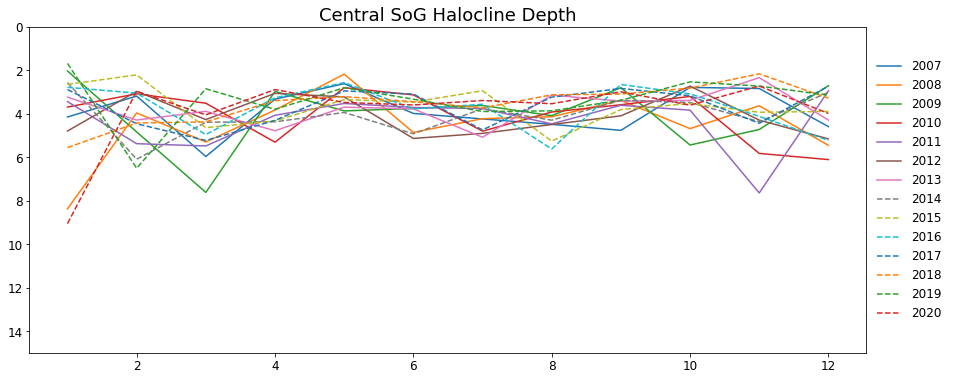

In [9]:
#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 6))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,7):
    ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[i,:],label=2007+i)
    ax.set_title('Central SoG Halocline',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,15)
    ax.set_ylabel('')
    ax.invert_yaxis()
   
for i in range(7,14):
    ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[i,:],linestyle='--',label=2007+i)
    ax.set_title('Central SoG Halocline Depth',fontsize=18)
    ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(0,15)
    ax.set_ylabel('')
    ax.invert_yaxis()

### Assign years to either NPGO+ or NPGO-

In [10]:
NPGOpositive_haloD=(((monthly_array_halocline_depth_SSslicemean[0,:]+monthly_array_halocline_depth_SSslicemean[1,:]+\
        monthly_array_halocline_depth_SSslicemean[2,:]+monthly_array_halocline_depth_SSslicemean[3,:]+\
        monthly_array_halocline_depth_SSslicemean[4,:]+monthly_array_halocline_depth_SSslicemean[5,:]+\
        monthly_array_halocline_depth_SSslicemean[6,:])/7))

In [11]:
NPGOpositive_haloD

array([4.25133574, 3.96408617, 5.15444407, 3.91312043, 3.13705961,
       4.05630268, 4.3817216 , 4.11156174, 3.67155466, 3.72985539,
       4.47659692, 4.47108673])

In [12]:
NPGOnegative_haloD=(((monthly_array_halocline_depth_SSslicemean[7,:]+monthly_array_halocline_depth_SSslicemean[8,:]+\
        monthly_array_halocline_depth_SSslicemean[9,:]+monthly_array_halocline_depth_SSslicemean[10,:]+\
        monthly_array_halocline_depth_SSslicemean[11,:]+monthly_array_halocline_depth_SSslicemean[12,:]+\
        monthly_array_halocline_depth_SSslicemean[13,:])/7))

In [13]:
NPGOnegative_haloD

array([3.88929908, 4.25111215, 4.36207933, 3.7705812 , 3.19168877,
       3.66776719, 3.7260692 , 4.14098257, 3.16912163, 3.18175432,
       3.50192818, 3.618502  ])

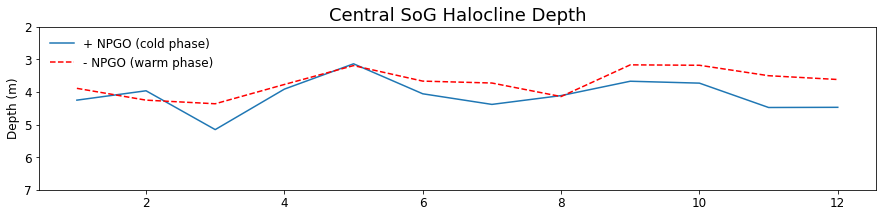

In [14]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), NPGOpositive_haloD,label='+ NPGO (cold phase)')
ax.plot(np.arange(1,13), NPGOnegative_haloD,linestyle='--',label='- NPGO (warm phase)',color='r')
ax.set_title('Central SoG Halocline Depth',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(2,7)
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
   

### Select 4 warmest and 4 coldest years; leave NPGO "neutral" years out

In [15]:
#2008, 2010, 2011, 2012
NPGO_C_Depth=(((+monthly_array_halocline_depth_SSslicemean[1,:]+\
        monthly_array_halocline_depth_SSslicemean[3,:]+\
        monthly_array_halocline_depth_SSslicemean[4,:]+monthly_array_halocline_depth_SSslicemean[5,:])/4))

In [16]:
#2017, 2018, 2019, 2020
NPGO_W_Depth=(((monthly_array_halocline_depth_SSslicemean[10,:]+\
        monthly_array_halocline_depth_SSslicemean[11,:]+monthly_array_halocline_depth_SSslicemean[12,:]+\
        monthly_array_halocline_depth_SSslicemean[13,:])/4))

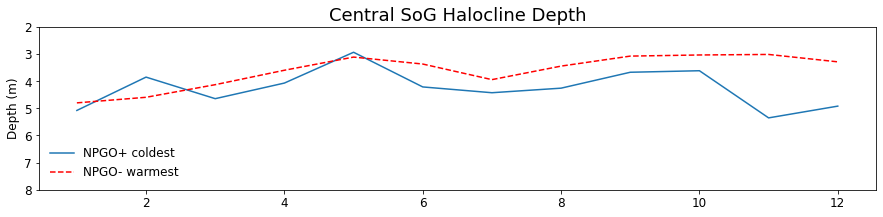

In [17]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), NPGO_C_Depth,linestyle='-',label='NPGO+ coldest')
ax.plot(np.arange(1,13), NPGO_W_Depth,linestyle='--',label='NPGO- warmest',color='r')
ax.set_title('Central SoG Halocline Depth',fontsize=18)
ax.legend(frameon=False,loc=3)
ax.set_ylim(2,8)
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()

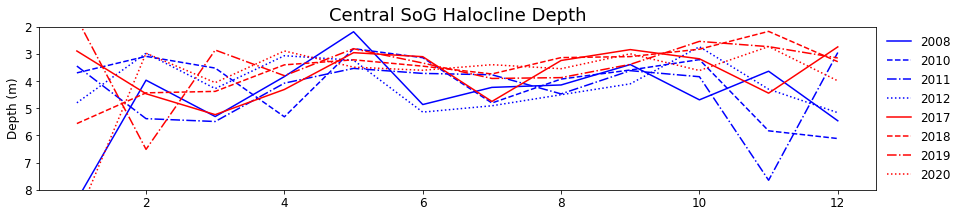

In [40]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[1,:],color='b',linestyle='-',label='2008')
ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[3,:],color='b',linestyle='--',label='2010')
ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[4,:],color='b',linestyle='-.',label='2011')
ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[5,:],color='b',linestyle=':',label='2012')
ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[10,:],color='r',linestyle='-',label='2017')
ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[11,:],color='r',linestyle='--',label='2018')
ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[12,:],color='r',linestyle='-.',label='2019')
ax.plot(np.arange(1,13), monthly_array_halocline_depth_SSslicemean[13,:],color='r',linestyle=':',label='2020')

ax.set_title('Central SoG Halocline Depth',fontsize=18)
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
ax.set_ylim(2,8)
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()

### Check Marine Heat Wave years

In [18]:
NoMHW_haloD=(((monthly_array_halocline_depth_SSslicemean[0,:]+monthly_array_halocline_depth_SSslicemean[1,:]+\
        monthly_array_halocline_depth_SSslicemean[2,:]+monthly_array_halocline_depth_SSslicemean[3,:]+\
        monthly_array_halocline_depth_SSslicemean[4,:]+monthly_array_halocline_depth_SSslicemean[5,:]+\
        monthly_array_halocline_depth_SSslicemean[6,:]+monthly_array_halocline_depth_SSslicemean[7,:]+monthly_array_halocline_depth_SSslicemean[10,:]+\
        monthly_array_halocline_depth_SSslicemean[11,:]+monthly_array_halocline_depth_SSslicemean[12,:]+\
        monthly_array_halocline_depth_SSslicemean[13,:])/12))

In [19]:
MHW_haloD=(((monthly_array_halocline_depth_SSslicemean[8,:]+monthly_array_halocline_depth_SSslicemean[9,:])/2))

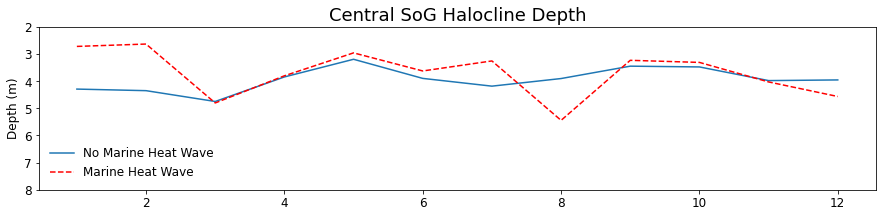

In [20]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), NoMHW_haloD,label='No Marine Heat Wave')
ax.plot(np.arange(1,13), MHW_haloD,linestyle='--',label='Marine Heat Wave',color='r')
ax.set_title('Central SoG Halocline Depth',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(2,8)
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()

# Halocline Strength

In [21]:
monthly_array_halocline_strength_SSslice[monthly_array_halocline_strength_SSslice == 0 ] = np.nan
monthly_array_halocline_strength_SSslicemean = \
np.nanmean(np.nanmean(monthly_array_halocline_strength_SSslice, axis = 2),axis = 2)
print(np.shape(monthly_array_halocline_strength_SSslicemean))

(14, 12)


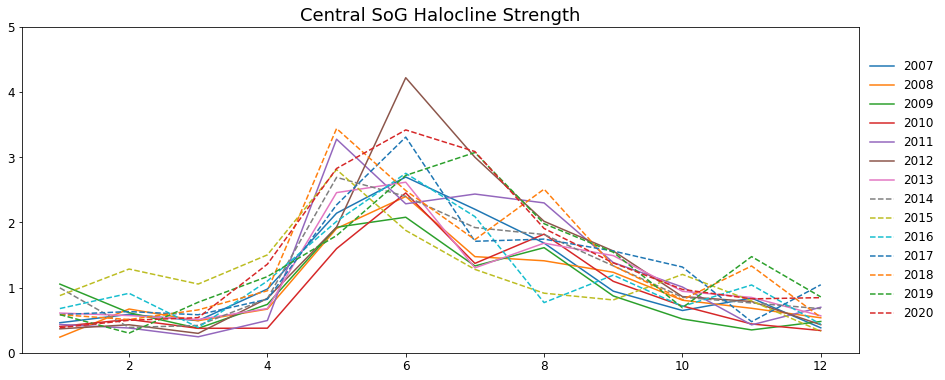

In [22]:
#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 6))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,7):
    ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[i,:],label=2007+i)
    ax.set_title('Central SoG Halocline',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,55)
    ax.set_ylabel('')
    #ax.invert_yaxis()
   
for i in range(7,14):
    ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[i,:],linestyle='--',label=2007+i)
    ax.set_title('Central SoG Halocline Strength',fontsize=18)
    ax.legend(frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(0,5)
    ax.set_ylabel('')
    #ax.invert_yaxis()

### Assign years to either NPGO+ or NPGO-

In [23]:
NPGOpositive_haloS=(((monthly_array_halocline_strength_SSslicemean[0,:]+monthly_array_halocline_strength_SSslicemean[1,:]+\
        monthly_array_halocline_strength_SSslicemean[2,:]+monthly_array_halocline_strength_SSslicemean[3,:]+\
        monthly_array_halocline_strength_SSslicemean[4,:]+monthly_array_halocline_strength_SSslicemean[5,:]+\
        monthly_array_halocline_strength_SSslicemean[6,:])/7))

In [24]:
NPGOpositive_haloS

array([0.51001935, 0.5382382 , 0.39853695, 0.68222104, 2.17499353,
       2.67648846, 1.87293183, 1.78826629, 1.22578886, 0.78619601,
       0.62540889, 0.49096949])

In [25]:
NPGOnegative_haloS=(((monthly_array_halocline_strength_SSslicemean[7,:]+monthly_array_halocline_strength_SSslicemean[8,:]+\
        monthly_array_halocline_strength_SSslicemean[9,:]+monthly_array_halocline_strength_SSslicemean[10,:]+\
        monthly_array_halocline_strength_SSslicemean[11,:]+monthly_array_halocline_strength_SSslicemean[12,:]+\
        monthly_array_halocline_strength_SSslicemean[13,:])/7))

In [26]:
NPGOnegative_haloS

array([0.67021589, 0.64664759, 0.63104741, 1.10448899, 2.54859834,
       2.70793635, 2.12671717, 1.66184646, 1.30691211, 0.93703761,
       0.95840066, 0.67616246])

Text(0, 0.5, '')

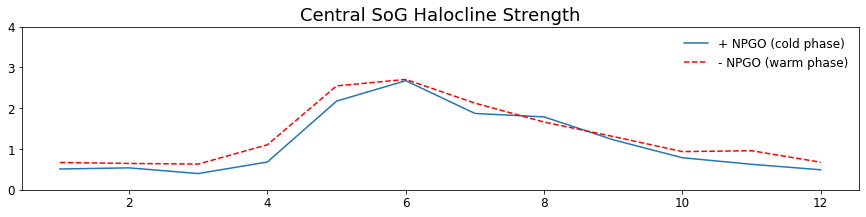

In [27]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), NPGOpositive_haloS,label='+ NPGO (cold phase)')
ax.plot(np.arange(1,13), NPGOnegative_haloS,linestyle='--',label='- NPGO (warm phase)',color='r')
ax.set_title('Central SoG Halocline Strength',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,4)
ax.set_ylabel('')
#ax.invert_yaxis()
   

### Select 4 warmest and 4 coldest years; leave NPGO "neutral" years out

In [28]:
#2008, 2010, 2011, 2012
NPGO_C_Strength=(((+monthly_array_halocline_strength_SSslicemean[1,:]+\
        monthly_array_halocline_strength_SSslicemean[3,:]+\
        monthly_array_halocline_strength_SSslicemean[4,:]+monthly_array_halocline_strength_SSslicemean[5,:])/4))

In [29]:
#2017, 2018, 2019, 2020
NPGO_W_Strength=(((monthly_array_halocline_strength_SSslicemean[10,:]+\
        monthly_array_halocline_strength_SSslicemean[11,:]+monthly_array_halocline_strength_SSslicemean[12,:]+\
        monthly_array_halocline_strength_SSslicemean[13,:])/4))

Text(0, 0.5, '')

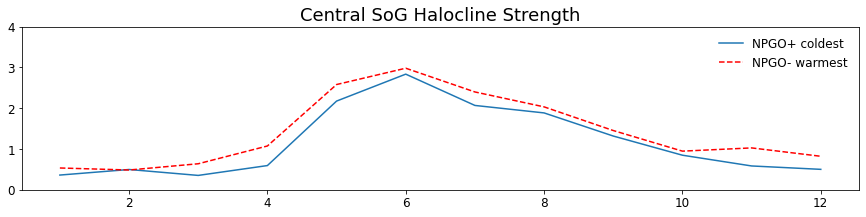

In [30]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), NPGO_C_Strength,linestyle='-',label='NPGO+ coldest')
ax.plot(np.arange(1,13), NPGO_W_Strength,linestyle='--',label='NPGO- warmest',color='r')
ax.set_title('Central SoG Halocline Strength',fontsize=18)
ax.legend(frameon=False,loc=1)
ax.set_ylim(0,4)
ax.set_ylabel('')
#ax.invert_yaxis()

Text(0, 0.5, '')

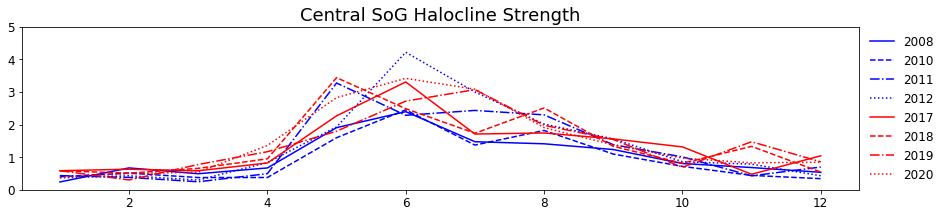

In [41]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[1,:],color='b',linestyle='-',label='2008')
ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[3,:],color='b',linestyle='--',label='2010')
ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[4,:],color='b',linestyle='-.',label='2011')
ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[5,:],color='b',linestyle=':',label='2012')
ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[10,:],color='r',linestyle='-',label='2017')
ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[11,:],color='r',linestyle='--',label='2018')
ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[12,:],color='r',linestyle='-.',label='2019')
ax.plot(np.arange(1,13), monthly_array_halocline_strength_SSslicemean[13,:],color='r',linestyle=':',label='2020')

ax.set_title('Central SoG Halocline Strength',fontsize=18)
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
ax.set_ylim(0,5)
ax.set_ylabel('')

### Check Marine Heat Wave years

In [31]:
NoMHW_haloS=(((monthly_array_halocline_strength_SSslicemean[0,:]+monthly_array_halocline_strength_SSslicemean[1,:]+\
        monthly_array_halocline_strength_SSslicemean[2,:]+monthly_array_halocline_strength_SSslicemean[3,:]+\
        monthly_array_halocline_strength_SSslicemean[4,:]+monthly_array_halocline_strength_SSslicemean[5,:]+\
        monthly_array_halocline_strength_SSslicemean[6,:]+monthly_array_halocline_strength_SSslicemean[7,:]+monthly_array_halocline_strength_SSslicemean[10,:]+\
        monthly_array_halocline_strength_SSslicemean[11,:]+monthly_array_halocline_strength_SSslicemean[12,:]+\
        monthly_array_halocline_strength_SSslicemean[13,:])/12))

In [32]:
MHW_haloS=(((monthly_array_halocline_strength_SSslicemean[8,:]+monthly_array_halocline_strength_SSslicemean[9,:])/2))

Text(0, 0.5, '')

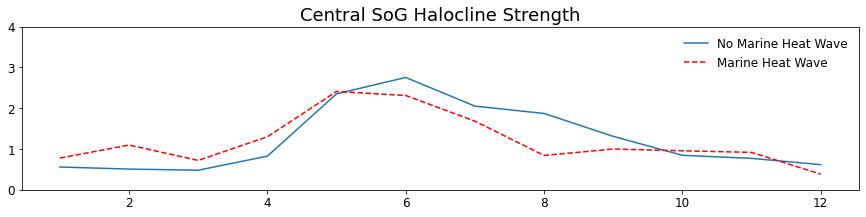

In [33]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), NoMHW_haloS,label='No Marine Heat Wave')
ax.plot(np.arange(1,13), MHW_haloS,linestyle='--',label='Marine Heat Wave',color='r')
ax.set_title('Central SoG Halocline Strength',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,4)
ax.set_ylabel('')
#ax.invert_yaxis()